## Computer vision application
## Data modeling - Production

This project aims to explore the computer vision field, from image processing operations to image classification. The data used here is made upon *2527 different images of garbage from 6 different classes*: cardboard, glass, metal, paper, plastic, trash. The ultimate goal is to develop an image classifier model that, after trained and validated using specific datasets, is able to predict the probabilities that a given image belongs to each of those classes. Again, a specific test dataset is applied to evaluate model performance. To achieve that goal, different code artifacts were generated:
* Python modules for image processing and to support model development.
* Notebooks of data engineering and data preparation that apply different operations over images (flip, crop, change in brightness, and so on).
* Notebooks of data modeling that implement experimentation to find the best image classifier model, analysis of the most relevant models and creation of codes to apply the best one in production.

-----------

This notebook was constructed to help building functions and classes so the developed model can be consumed in production. Besides, this notebook illustrates how to use these functions and classes.

**Sumário:**
1. [Libraries](#libraries)<a href='#libraries'></a>.
2. [Functions and classes](#functions_classes)<a href='#functions_classes'></a>.
3. [Settings](#settings)<a href='#settings'></a>.
4. [Imports](#imports)<a href='#imports'></a>.
5. [Predictions](#predictions)<a href='#predictions'></a>.

<a id='libraries'></a>

## Libraries





In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
cd "/content/gdrive/MyDrive/Studies/computer_vision/notebooks/"

/content/gdrive/MyDrive/Studies/computer_vision/notebooks


In [3]:
# !pip install -r ../requirements.txt

In [4]:
import pandas as pd
import numpy as np
import os
import json
from datetime import datetime
import time
import cv2
from copy import deepcopy
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import sys

sys.path.append(
    os.path.abspath(
        os.path.join(
            os.path.dirname(__doc__), '../src'
        )
    )
)

<a id='functions_classes'></a>

## Functions and classes

In [6]:
from production import data_prep, predict_proba, predict, Outputs

<a id='settings'></a>

## Settings

<a id='files_manag'></a>

### Files management

In [7]:
# Declare whether outcomes should be exported:
export = False

# Declare whether to scale images:
scale = True

# Model identification:
exp_id = '1672278906'

<a id='image_files'></a>

### Image files

In [8]:
# Available classes:
classes = os.listdir('../data/images/')

# Dictionary with label by class:
label_dict = dict(zip(classes, [i+1 for i in range(len(classes))]))
print(label_dict)

# Function to convert labels into classes:
label_to_class = dict(zip(label_dict.values(), label_dict.keys()))

# File names of each dataset:
test_images = [f.split('.')[0] for f in list(pd.read_csv('../data/test_images.txt', sep=' ', header=None)[0])]

{'cardboard': 1, 'glass': 2, 'metal': 3, 'paper': 4, 'plastic': 5, 'trash': 6}


<a id='imports'></a>

## Imports

<a id='data_prep'></a>

### Importing and preparing images

Text(0.5, 1.0, 'cardboard51')

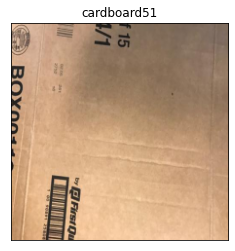

In [9]:
# Randomly selecting an image so it can be classified:
random_img = np.random.choice(test_images)
img_class = ''.join([x for x in random_img if x not in '0123456789'])
upload_time = int(time.time())

# Reading and preparing the image:
img, resized_img, scaled_img = data_prep(
    path=f'../data/images/{img_class}/{random_img}.jpg'
)

# Showing the image:
plt.imshow(scaled_img)
plt.xticks([])
plt.yticks([])
plt.title(random_img)

<a id='import_models'></a>

### Importing models

In [10]:
# Model assessment:
with open(f'../experiments/model_assess_{exp_id}.json', 'rb') as json_file:
    model_assess = json.load(json_file)

# Loading the selected model:
model = pickle.load(open(f'../artifacts/model_{exp_id}.pickle', 'rb'))

# Saving the model with different extension (h5):
model.model.save(f'../artifacts/model_{exp_id}.h5')

<a id='predictions'></a>

## Predictions

<a id='predict_funcs'></a>

### Predict functions

Text(0.5, 1.0, 'trash1')

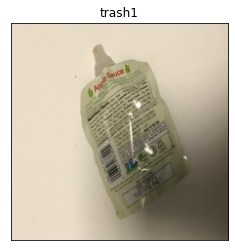

In [11]:
# Declaring an image so it can be classified:
random_img = 'trash1'
img_class = ''.join([x for x in random_img if x not in '0123456789'])
upload_time = int(time.time())

# Reading and preparing the image:
img, resized_img, scaled_img = data_prep(
    path=f'../data/images/{img_class}/{random_img}.jpg'
)

# Showing the image:
plt.imshow(scaled_img)
plt.xticks([])
plt.yticks([])
plt.title(random_img)

In [ ]:
# Predicted probabilities of image belonging to each class:
predicted_prob = predict_proba(
    model=model,
    img=scaled_img
)
prob_df = pd.DataFrame(
    data={
        'class': list(label_dict.keys()),
        'probability': predicted_prob
    }
)

# Predicted class of the image:
predicted_label, predicted_class = predict(
    model=model,
    img=scaled_img,
    label_to_class=label_to_class
)

print(f'Predicted class: {predicted_class}')
prob_df.T

Predicted class: plastic


,0,1,2,3,4,5
class,cardboard,glass,metal,paper,plastic,trash
probability,0.0,0.0,0.000003,0.0,0.999953,0.000044


<a id='storing_outputs'></a>

### Storing outputs

In [ ]:
# Schema of outputs table:
schema = {
    'file_name': str, 'epoch': int,
    'cardboard': float,
    'glass': float,
    'metal': float,
    'paper': float,
    'plastic': float,
    'trash': float,
    'pred_class': str, 'true_class': str,
    'model_id': str
}

# Creating the output table:
outputs = Outputs(
    columns=list(schema.keys()),
    dtypes=list(schema.values())
)
outputs.display()

,file_name,epoch,cardboard,glass,metal,paper,plastic,trash,pred_class,true_class,model_id


In [ ]:
# Creating new output from the prediction over sample image:
new_output = pd.DataFrame(
    data={
        'file_name': random_img, 'epoch': upload_time,
        'cardboard': predicted_prob[0],
        'glass': predicted_prob[1],
        'metal': predicted_prob[2],
        'paper': predicted_prob[3],
        'plastic': predicted_prob[4],
        'trash': predicted_prob[5],
        'pred_class': predicted_class, 'true_class': img_class,
        'model_id': exp_id
    },
    index=[0]
)

# Updating the outputs table:
outputs.update(new_output)
outputs.display()

,file_name,epoch,cardboard,glass,metal,paper,plastic,trash,pred_class,true_class,model_id
0,trash1,1674689461,3.621268e-10,1.658815e-08,0.000003,2.717784e-08,0.999953,0.000044,plastic,trash,1672278906
